<a href="https://colab.research.google.com/github/ganesh75690/garbage-aicte/blob/main/garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [1]:
from google.colab import files
from zipfile import ZipFile

# Upload your dataset ZIP file
uploaded = files.upload()


Saving garbage.zip to garbage.zip


In [2]:
with ZipFile("garbage.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [3]:
dataset_dir= r"D:\garbage\TrashType_Image_Dataset"
image_size = (128, 128)
batch_size = 32
seed = 42

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/TrashType_Image_Dataset",   # dataset_dir
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=(128, 128),
    batch_size=32
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/TrashType_Image_Dataset",    # dataset_dir
    validation_split=0.2,
    subset="validation",
    seed=123,                      # seed
    shuffle=True,
    image_size=(128, 128),        # image_size
    batch_size=32                 # batch_size
)

val_class = val_ds.class_names
print("Validation Classes:", val_class)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Validation Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [8]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [9]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


In [10]:
import matplotlib.pyplot as plt

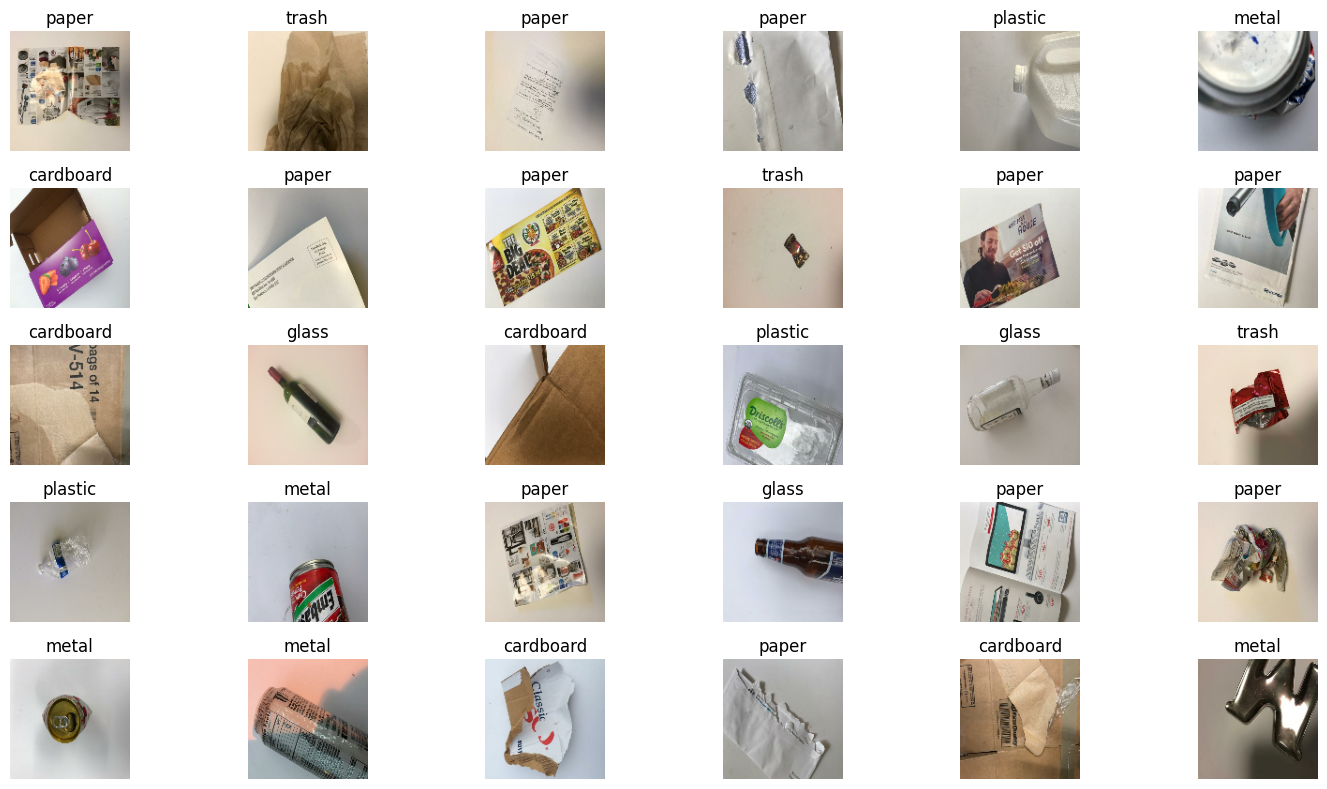

In [32]:
num_images = min(30, len(images))  # Ensure you don't exceed the length
plt.figure(figsize=(15, 8))
for i in range(num_images):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [33]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [34]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [35]:
class_names = train_ds.class_names

train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 16.44, 'glass': 20.4, 'metal': 15.45, 'paper': 24.55, 'plastic': 17.43, 'trash': 5.74}
{'cardboard': 16.8, 'glass': 23.83, 'metal': 16.02, 'paper': 22.27, 'plastic': 15.62, 'trash': 5.47}
{'cardboard': 16.48, 'glass': 20.06, 'metal': 15.68, 'paper': 23.92, 'plastic': 18.44, 'trash': 5.42}


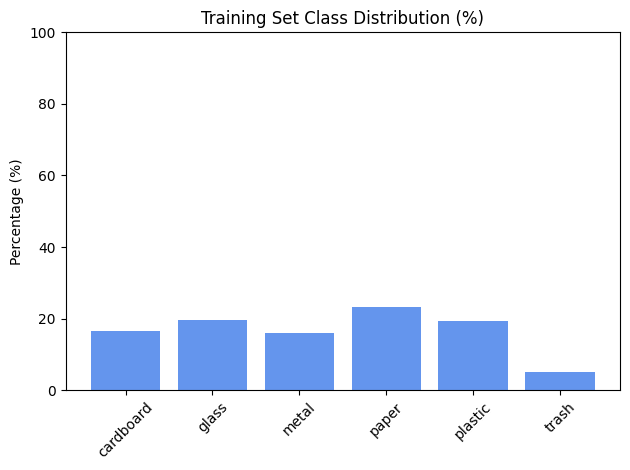

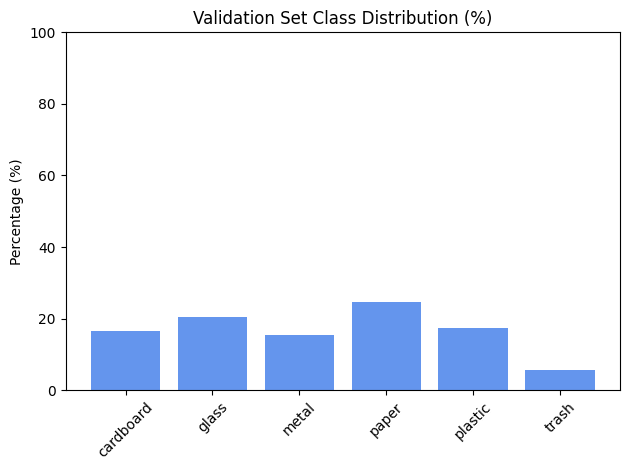

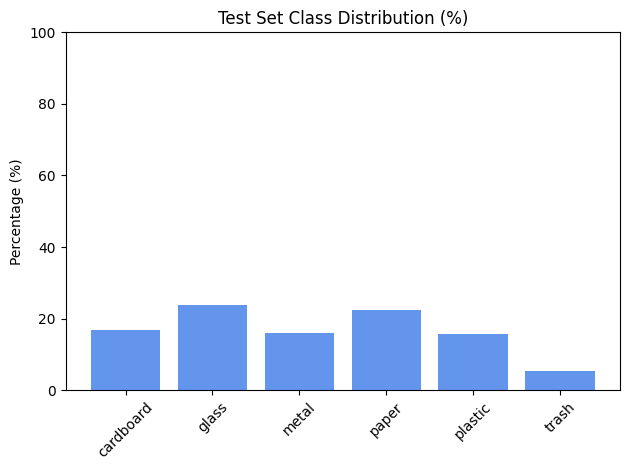

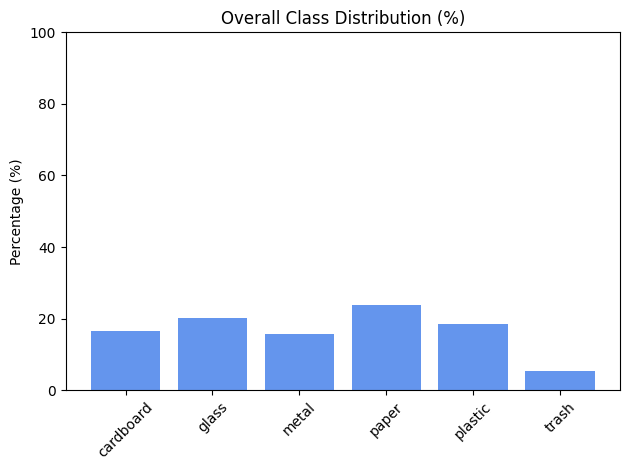

In [36]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")